In [1]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
import zipfile
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

In [2]:
zip_path = "adult.zip"

columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]

with zipfile.ZipFile(zip_path) as z:
    # Load training data
    df_train = pd.read_csv(
        z.open("adult.data"),
        names=columns,
        sep=",",
        na_values="?",
        skipinitialspace=True
    )
    
    # Load test data (skip first line because it contains a comment)
    df_test = pd.read_csv(
        z.open("adult.test"),
        names=columns,
        sep=",",
        na_values="?",
        skipinitialspace=True,
        skiprows=1
    )

df = pd.concat([df_train, df_test], ignore_index=True)
df["income"] = df["income"].str.replace(".", "", regex=False)
df["income"] = df["income"].str.strip()

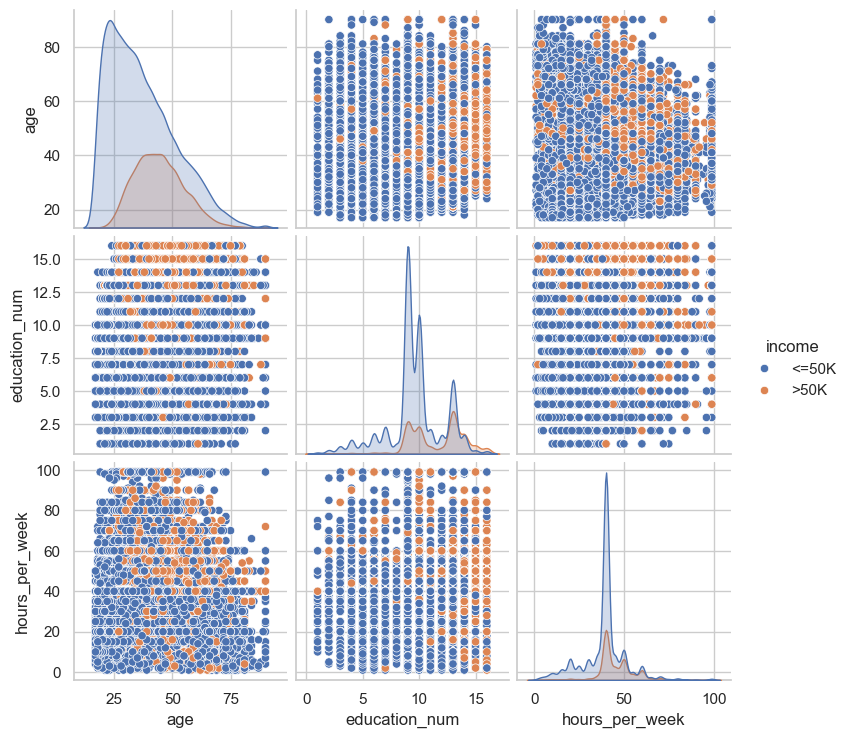

In [3]:
sns.set(style="whitegrid")

sns.pairplot(df[["age", "education_num", "hours_per_week", "income"]], hue="income")
plt.show()

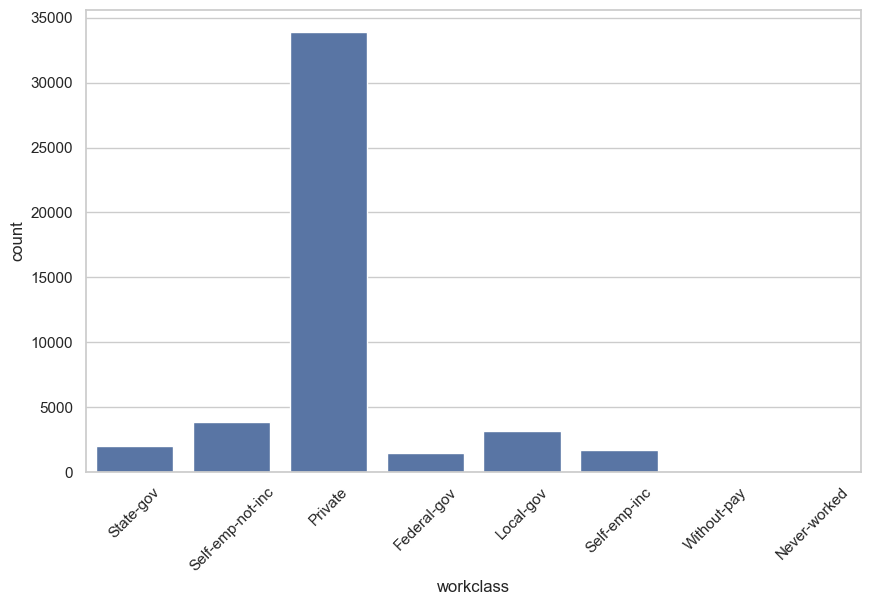

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="workclass")
plt.xticks(rotation=45)
plt.show()

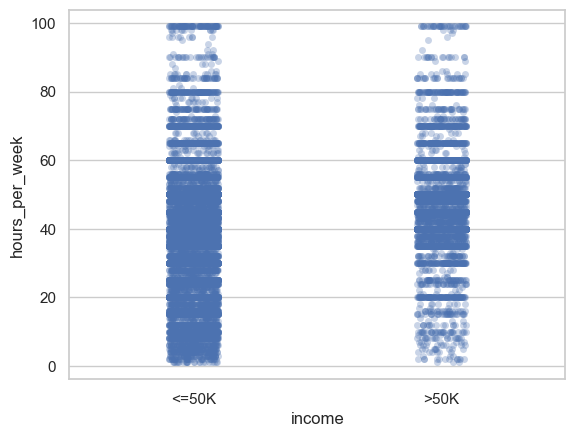

In [5]:
sns.stripplot(data=df, x="income", y="hours_per_week", alpha=0.3)
plt.show()

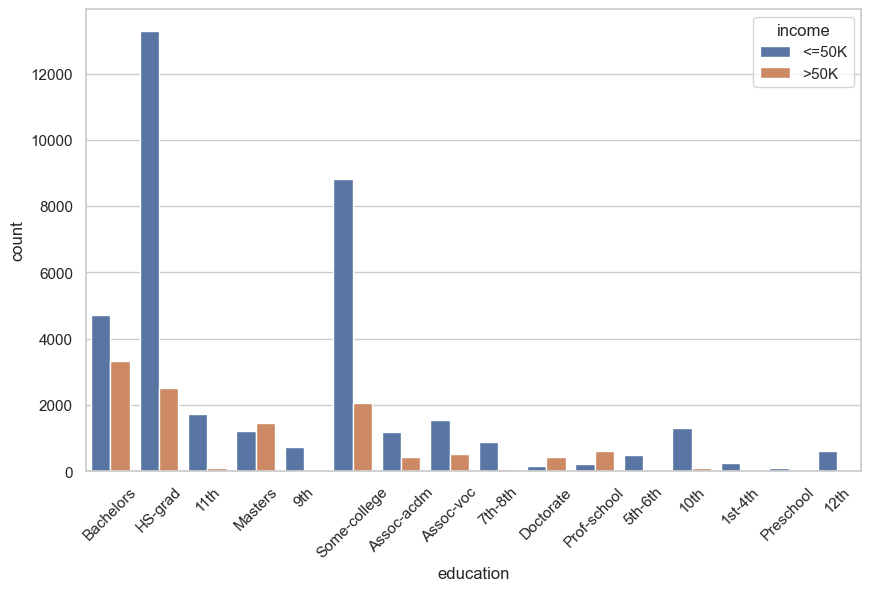

In [6]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="education", hue="income")
plt.xticks(rotation=45)
plt.show()

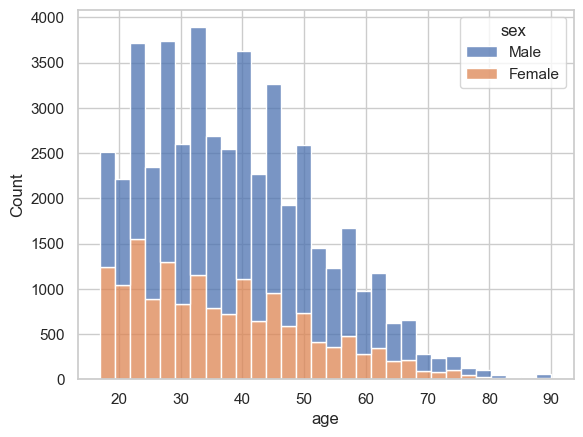

In [7]:
sns.histplot(
    data=df,
    x="age",
    hue="sex",
    bins=30,
    multiple="stack"
)
plt.show()

In [8]:
# Linear Regression

from sklearn.model_selection import train_test_split
from typing import Tuple
import numpy as np
from sklearn.model_selection import train_test_split

def get_train_valid_test_data(X: np.ndarray, y: np.ndarray, ):
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

def get_preprocessed_data() -> Tuple[np.ndarray]:
    """ Gets preprocessed data for training, validation, and testing

        Returns:
            A tuple of NumPy arrays where indices 0-1 
            contain the training data/targets, indices 2-3
            contain the validation data/targets, and 4-5
            contain the testing data/targets.
    """
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = None, None, None, None, None, None
    # Drop the label column and store the features (pixel values) in X
    X = df.drop('label', axis=1).values
    y = df['label'].values
    
    # TODO 3.1 - 3.4
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    y = df['label'].values.reshape(-1,1)
    encoder = OneHotEncoder(sparse_output=False)
    y_encoded = encoder.fit_transform(y)

    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X, y_encoded)

    scaler = StandardScaler()
    X_trn = scaler.fit_transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)

    def add_bias(X):
        bias = np.ones((X.shape[0], 1))
        return np.hstack((bias, X))

    X_trn = add_bias(X_trn)
    X_vld = add_bias(X_vld)
    X_tst = add_bias(X_tst)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

def plot_decision_boundary(
    softreg: object, 
    X: np.ndarray, 
    y: np.ndarray,
    xlabel: str = '',
    ylabel: str = '',
    class_names: Dict = None
) -> None:
    """ Plots the decision boundry for data with 2 features. 
    
        Warning: 
            If you have more than 2 features (2D data) the decision boundry
            can not be plotted.
    
        Args:
            softreg: An instance of SoftmaxRegression class
            
            X: Data to be plotted

            y: Labels for corresponding data

            xlabel: X-axis label for plot

            ylabel: Y-axis label for plot
            
            class_names: Dictionary mapping labels to class names.
    """
    assert X.shape[-1] == 2, f"`X` must have 2 features not {X.shape[-1]}"
        
    if class_names is None:
        class_names = {}

    # Generate fake data to cover entire space of our input features X
    buffer = .5
    x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer
    y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                         np.arange(y_min, y_max, .02))
    fake_data = np.c_[xx.ravel(), yy.ravel()].reshape(-1,2)
    fake_data =  np.hstack([np.ones((len(fake_data), 1)), fake_data])
    # Make prediction
    y_hat = softreg.predict(fake_data)

    # Plot
    plt.contourf(xx, yy, y_hat.reshape(xx.shape))
    
    labels = np.unique(y)
    for l in labels:
        class_locs = np.where(y == l)[0]
        class_name = class_names.get(l, f'class {l}')
        plt.scatter(X[class_locs, 0], X[class_locs, 1], label=class_name)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names: Dict[int, str] = None,
    figsize: Tuple = (10, 5)
) -> pd.DataFrame:
    """ Plots a pretty and labeld version of Sklerarn's confusion matrix

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

            class_names: Dictionary mapping labels to class names.

                Example: {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

            figsize: A tuple for setting the width and height of the plot.

        Returns:
            A confusion matrix casted as a DataFrame
    """
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency
    
    cfm = confusion_matrix(y_true=y, y_pred=y_hat)    
    
    labels = np.sort(np.unique(y))
    if class_names is not None:
        classes = []
        for l in labels:
            class_name = class_names.get(l, l)
            classes.append(class_name)
        labels = classes
        
    columns, index = labels, labels
    fig, ax = plt.subplots(figsize=figsize)  
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    sns.heatmap(cfm_df, annot=True, fmt='g', ax=ax)
    plt.show()
    return cfm_df

def sigmoid(z: np.ndarray) -> np.ndarray:
    # TODO 4
    return np.exp(z) / (1 + np.exp(z))
    pass

def softmax(z: np.ndarray) -> np.ndarray:
    """ Computes the stablized version of the softmax

        Args:
            z: A vector or matrix of continuous values.

        Returns:
            A NumPy array with the same shape as the input.
    """
    # TODO 5
    z_max = np.max(z, axis=1, keepdims=True)

    exp_z = np.exp(z - z_max)

    softmax_values = exp_z / np.sum(exp_z, axis=1, keepdims=True)

    return softmax_values

    pass

def nll_loss(y: np.ndarray, probs: np.ndarray) -> float:
    """ Computes the average generalized NLL Loss

        Args:
            y: The ground truth one-hot encoded labels
                given as matrix of shape (N, K).

            probs: The predicted probabilities for the
                corresponding labels given as a matrix
                of shape (N, K)
        Returns:
            A NLL loss given as a float.
    """
    # TODO 6

    eps = 1e-15
    probs = np.clip(probs, eps, 1 - eps)

    nll = -np.mean(np.sum(y * np.log(probs), axis=1))

    return nll
    pass

def get_batches(
    data_len: int, 
    batch_size: int = 32,
) -> List[np.ndarray]:
    """ Generates mini-batches based on the data indexes
        
        Args:
            data_len: Length of the data or number of data samples 
                in the data. This is used to generate the indices of
                the data.
            
            batch_size: Size of each mini-batch where the last mini-batch
                might be smaller than the rest if the batch_size does not 
                evenly divide the data length.

        Returns:
            A list of NumPy array's holding the indices of batches
    """
    indices = np.arange(data_len)
    np.random.shuffle(indices)
    batches = [indices[i:i+batch_size] for i in range(0, data_len, batch_size)]

    return batches

class SoftmaxRegression():
    """ Performs softmax regression using gradient descent
    
        Attributes:

            alpha: learning rate or step size.
                
            batch_size: Size of mini-batches for mini-batch gradient
                descent.
            
            epochs: Number of epochs to run for mini-batch
                gradient descent.
                
            seed: Seed to be used for NumPy's RandomState class
                or universal seed np.random.seed() function.

            W: Matrix of weights with shape (M, K) 

            trn_loss: Stores the training loss for each epoch.

            vld_loss: Stores the validation loss for each epoch.
    """
    def __init__(
        self, 
        alpha: float,
        batch_size: int,
        epochs: int = 1,
        seed: int = 0,
    ):

        self.alpha = alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        
        self.W = None
        self.trn_loss = None
        self.vld_loss = None
    
    def fit(
         self, 
         X: np.ndarray, 
         y: np.ndarray, 
         X_vld: np.ndarray=None, 
         y_vld: np.ndarray=None
     ) -> object:
        """ Trains softmax regressio using SGD
        
            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 2D column vector

                X_vld: Validation data given as a 2D matrix. Used 
                    to compute the validation accuracy for each epoch.

                y_vld: Validation labels given as a 2D matrix. Used 
                    to compute the validation accuracy for each epoch.
                
            Returns:
                The class's own object reference. 
        """

        np.random.seed(self.seed)
        self.trn_loss = []
        self.vld_loss = []

        # TODO 7.1
        n_features = X.shape[1]
        n_classes = y.shape[1]
        self.W = np.random.rand(n_features, n_classes)

        for e in range(self.epochs):
            batches = get_batches(len(X), self.batch_size)

            for b in batches:
                X_b = X[b]
                y_b = y[b]
                Z = X_b @ self.W
                Y_hat = softmax(Z)
                grad_W = (X_b.T @ (Y_hat - y_b)) / X_b.shape[0]
                self.W -= self.alpha * grad_W

            trn_probs = softmax(X @ self.W)
            trn_loss = nll_loss(y, trn_probs)
            self.trn_loss.append(trn_loss)
            
            if X_vld is not None and y_vld is not None:
                vld_probs = softmax(X_vld @ self.W)
                vld_loss = nll_loss(y_vld, vld_probs)
                self.vld_loss.append(vld_loss)
        
        return self
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Make predictions using learned weights

            Args:
                X: Testing data given as a 2D matrix

            Returns:
                A 2D column vector of predictions for each data sample in X
        """
        # TODO 7.2
        probs = softmax(X @ self.W)
        preds = np.argmax(probs, axis=1).reshape(-1, 1)
        return preds

        pass

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# TODO 8: Training Code
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()

model = SoftmaxRegression(alpha=0.05, batch_size=64, epochs=20, seed=42)
model.fit(X_trn, y_trn, X_vld, y_vld)

y_trn_pred = model.predict(X_trn)

y_trn_true = np.argmax(y_trn, axis=1).reshape(-1, 1)

train_acc = accuracy_score(y_trn_true, y_trn_pred)
print(f"Training Accuracy: {train_acc:.4f}")

plt.figure(figsize=(8,5))
plt.plot(model.trn_loss, label="Training Loss", linewidth=2)
plt.plot(model.vld_loss, label="Validation Loss", linewidth=2)
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("NLL Loss")
plt.legend()
plt.grid(True)
plt.show()

cm_trn = confusion_matrix(y_trn_true, y_trn_pred)
disp_trn = ConfusionMatrixDisplay(confusion_matrix=cm_trn, display_labels=list(label2name.values()))
disp_trn.plot(cmap='Blues', xticks_rotation=45)
plt.title("Training Confusion Matrix")
plt.show()

y_vld_pred = model.predict(X_vld)
y_vld_true = np.argmax(y_vld, axis=1).reshape(-1, 1)

val_acc = accuracy_score(y_vld_true, y_vld_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

cm_vld = confusion_matrix(y_vld_true, y_vld_pred)
disp_vld = ConfusionMatrixDisplay(confusion_matrix=cm_vld, display_labels=list(label2name.values()))
disp_vld.plot(cmap='Oranges', xticks_rotation=45)
plt.title("Validation Confusion Matrix")
plt.show()

# TODO 8: Testing Code
y_tst_pred = model.predict(X_tst)
y_tst_true = np.argmax(y_tst, axis=1).reshape(-1, 1)

test_acc = accuracy_score(y_tst_true, y_tst_pred)
print(f"Testing Accuracy: {test_acc:.4f}")

cm_tst = confusion_matrix(y_tst_true, y_tst_pred)
disp_tst = ConfusionMatrixDisplay(confusion_matrix=cm_tst, display_labels=list(label2name.values()))
disp_tst.plot(cmap='Greens', xticks_rotation=45)
plt.title("Testing Confusion Matrix")
plt.show()



KeyError: "['label'] not found in axis"